In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Preprocessing

In [ ]:
import os
import numpy as np
import gc
from tensorflow.keras.utils import to_categorical

# --- Load the NPZ Files (including meta arrays) ---
train_data = np.load('train-dataset.npz')
X_train = train_data["X"]
y_train = train_data["y"]
meta_train = train_data["meta"]

valid_data = np.load('valid-dataset.npz')
X_valid = valid_data["X"]
y_valid = valid_data["y"]
meta_valid = valid_data["meta"]

test_data = np.load('test-dataset.npz')
X_test = test_data["X"]
y_test = test_data["y"]
meta_test = test_data["meta"]

# Check current shapes before transpose
print("Before transpose:")
print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_valid shape:", X_valid.shape, "y_valid shape:", y_valid.shape)
print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)

# Transpose the MFCC data to (batch, height, width, channels)
X_train = np.transpose(X_train, (0, 2, 3, 1))
X_valid = np.transpose(X_valid, (0, 2, 3, 1))
X_test  = np.transpose(X_test,  (0, 2, 3, 1))

print("After transpose:")
print("X_train shape:", X_train.shape)
print("X_valid shape:", X_valid.shape)
print("X_test shape:", X_test.shape)

# Calculate the mean and std from training images (do not normalize meta data)
mean = np.mean(X_train)
std = np.std(X_train)
print("Normalization parameters: mean =", mean, "std =", std)

X_train = (X_train - mean) / std
X_valid = (X_valid - mean) / std
X_test  = (X_test  - mean) / std

gc.collect()




Before transpose:
X_train shape: (8292, 1, 12, 380) y_train shape: (8292, 4)
X_valid shape: (2000, 1, 12, 380) y_valid shape: (2000, 4)
X_test shape: (518, 1, 12, 380) y_test shape: (518, 4)
After transpose:
X_train shape: (8292, 12, 380, 1)
X_valid shape: (2000, 12, 380, 1)
X_test shape: (518, 12, 380, 1)
Normalization parameters: mean = -25.11812081253392 std = 144.93311575451642


44

In [ ]:
# -------------------------------------------------------------------
# Define the model with two inputs: one for MFCC images and one for meta data
# -------------------------------------------------------------------
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, Add, Activation, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

def res_block(input_tensor, filters, kernel_size=(3,3), strides=(1,1), weight_decay=0.1):
    # Main branch: two Conv2D layers with BatchNormalization and ReLU activation
    x = Conv2D(filters, kernel_size, padding='same', strides=strides,
               activation='relu', kernel_regularizer=l2(weight_decay))(input_tensor)
    x = BatchNormalization()(x)
    x = Conv2D(filters, kernel_size, padding='same', strides=(1,1),
               activation=None, kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)

    # Shortcut branch: adjust dimensions if needed
    shortcut = input_tensor
    if shortcut.shape[-1] != filters or strides != (1,1):
        shortcut = Conv2D(filters, (1,1), strides=strides, padding='same',
                          kernel_regularizer=l2(weight_decay))(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# Input for MFCC images (channels-last format)
img_input = Input(shape=(X_train.shape[1], X_train.shape[2], 1), name='img_input')

# CNN branch for MFCC images
x = Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.1))(img_input)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = res_block(x, 64, strides=(1,1), weight_decay=0.1)
x = MaxPooling2D((2,2))(x)

x = res_block(x, 128, strides=(1,1), weight_decay=0.1)
x = MaxPooling2D((2,2))(x)

x = res_block(x, 256, strides=(1,1), weight_decay=0.1)
x = MaxPooling2D((2,2), padding="same")(x)

x = res_block(x, 512, strides=(1,1), weight_decay=0.1)
x = MaxPooling2D((2,2), padding="same")(x)

# Flatten CNN features
x = Flatten()(x)

# Input for meta data (age and gender, shape = (2,))
meta_input = Input(shape=(meta_train.shape[1],), name='meta_input')
# Optionally, pass meta features through a small dense network
m = Dense(32, activation='relu')(meta_input)

# Concatenate CNN features and meta features
combined = Concatenate()([x, m])

# Fully Connected MLP layers after fusion
fc = Dense(512, activation='relu', kernel_regularizer=l2(0.1))(combined)
fc = Dropout(0.5)(fc)
fc = Dense(256, activation='relu', kernel_regularizer=l2(0.1))(fc)
fc = Dropout(0.4)(fc)
fc = Dense(128, activation='relu', kernel_regularizer=l2(0.1))(fc)
fc = Dropout(0.4)(fc)
fc = Dense(64, activation='relu', kernel_regularizer=l2(0.1))(fc)
fc = Dropout(0.4)(fc)

# Output layer
num_classes = y_train.shape[1]
output = Dense(num_classes, activation='softmax')(fc)

# Create and compile the model
model_resnet = Model(inputs=[img_input, meta_input], outputs=output)
model_resnet.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])
model_resnet.summary()




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img_input           │ (None, 12, 380,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 12, 380,   │        320 │ img_input[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 12, 380,   │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 6, 190,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 6, 190,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 190,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 6, 190,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 6, 190,    │      2,112 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 190,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 190,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 6, 190,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 6, 190,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 3, 95, 64) │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 3, 95,     │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3, 95,     │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 3, 95,     │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 3, 95,     │      8,320 │ max_pooling2d_1[

 Total params: 8,224,548 (31.37 MB)

 Trainable params: 8,218,724 (31.35 MB)

 Non-trainable params: 5,824 (22.75 KB)

In [ ]:
# -------------------------------------------------------------------
# Train the model using the fused inputs
# -------------------------------------------------------------------
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model_resnet.fit(
    [X_train, meta_train], y_train,
    validation_data=([X_valid, meta_valid], y_valid),
    epochs=100,
    batch_size=128,
    callbacks=[lr_scheduler]
)

Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 71s 559ms/step - accuracy: 0.2660 - loss: 353.7558 - val_accuracy: 0.3240 - val_loss: 277.1632 - learning_rate: 1.0000e-04
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.2741 - loss: 256.3840 - val_accuracy: 0.2500 - val_loss: 201.5183 - learning_rate: 1.0000e-04
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.2927 - loss: 187.1317 - val_accuracy: 0.2500 - val_loss: 149.3641 - learning_rate: 1.0000e-04
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.3034 - loss: 139.4097 - val_accuracy: 0.2515 - val_loss: 113.2430 - learning_rate: 1.0000e-04
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.3322 - loss: 106.2328 - val_accuracy: 0.2500 - val_loss: 87.7980 - learning_rate: 1.0000e-04
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.3633 - loss: 82.7273 - val_accuracy: 0.2500 - val_loss: 69.4551 - learning_rate: 1.0000e-04
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s

17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 200ms/step - accuracy: 0.7054 - loss: 1.4617
Final Accuracy on Test Set: 0.700772225856781
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step
              precision    recall  f1-score   support

      canada       0.56      0.72      0.63        99
     england       0.88      0.67      0.76       298
      indian       0.72      0.72      0.72        90
    scotland       0.36      0.84      0.50        31

    accuracy                           0.70       518
   macro avg       0.63      0.74      0.65       518
weighted avg       0.76      0.70      0.72       518



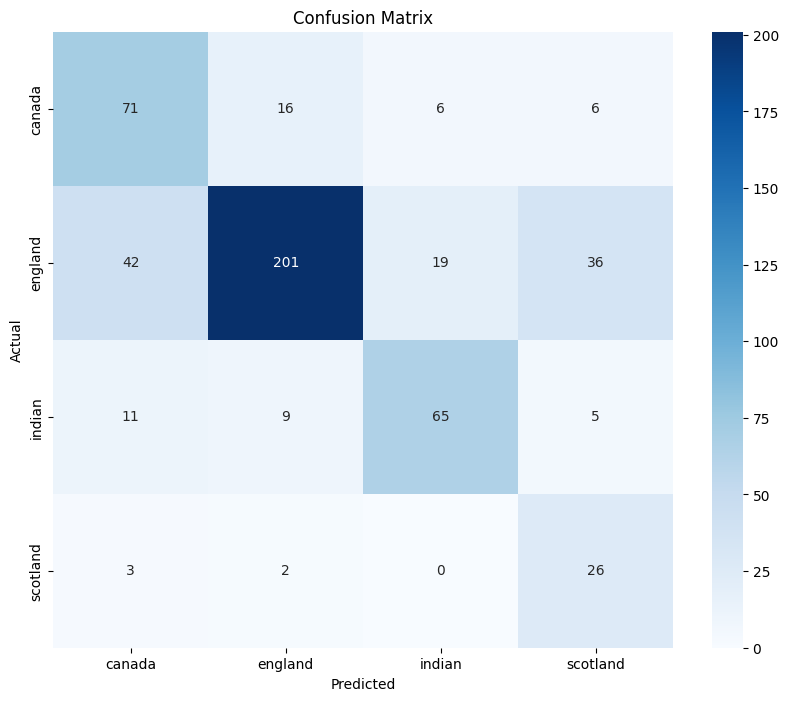

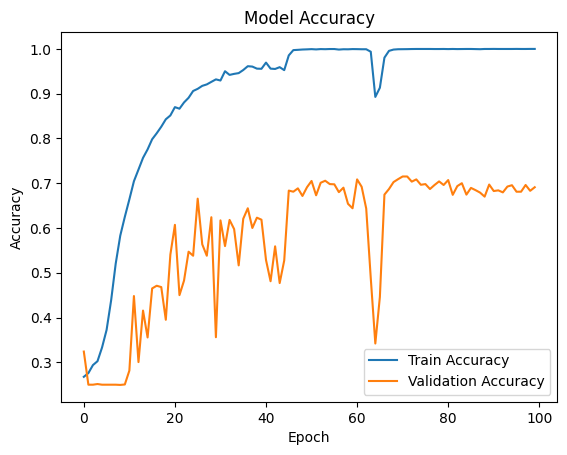

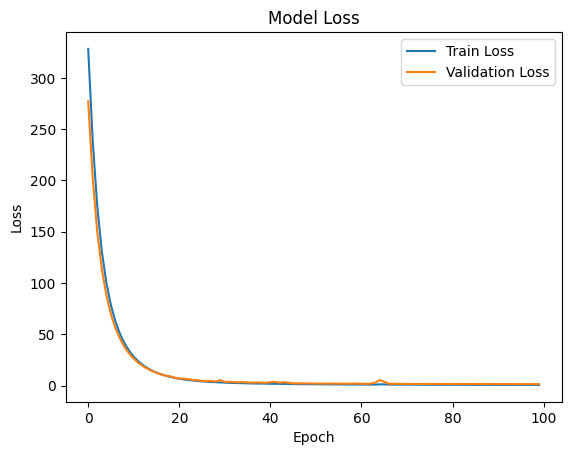

In [ ]:
# -------------------------------------------------------------------
# Evaluate the Model on Test Data
# -------------------------------------------------------------------
test_loss, test_accuracy = model_resnet.evaluate([X_test, meta_test], y_test)
print("Final Accuracy on Test Set:", test_accuracy)

# For reporting, assume you have the following label mapping:
label_mapping = {0: 'canada', 1: 'england', 2: 'indian', 3: 'scotland'}
target_names = [label_mapping[i] for i in range(len(label_mapping))]

# --- Generate predictions and compute evaluation metrics ---
y_pred = model_resnet.predict([X_test, meta_test])
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print(classification_report(y_true_labels, y_pred_labels, target_names=target_names))
cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# --- Plot Training History ---
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend()
plt.show()


In [ ]:
# --- Save the Model ---
model_resnet.save("model_mfcc.h5")

# For environments that support file links (like Kaggle or Jupyter Notebook)
from IPython.display import FileLink
FileLink('model_mfcc.h5')

/content/model_mfcc.h5